[[3.2399998 3.2399998 3.2300014 ... 3.2300034 3.1800003 3.170002 ]
 [3.2600002 3.2600002 3.25      ... 3.170002  3.119999  3.1800003]
 [3.250002  3.2600002 3.2399998 ... 3.1599998 3.1600037 3.2299995]
 ...
 [3.0700035 3.0900002 3.0700035 ... 3.2399979 3.2400017 3.2600021]
 [3.0699997 3.1000023 3.0600014 ... 3.2400017 3.25      3.25     ]
 [3.0800018 3.0800018 3.0100021 ... 3.2700005 3.2600021 3.2300034]]


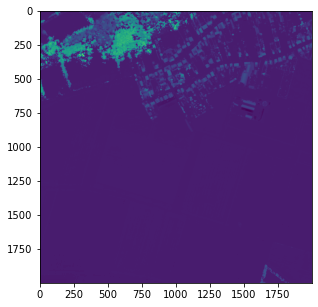

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


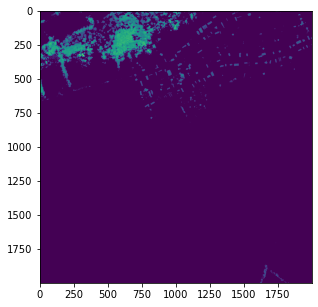

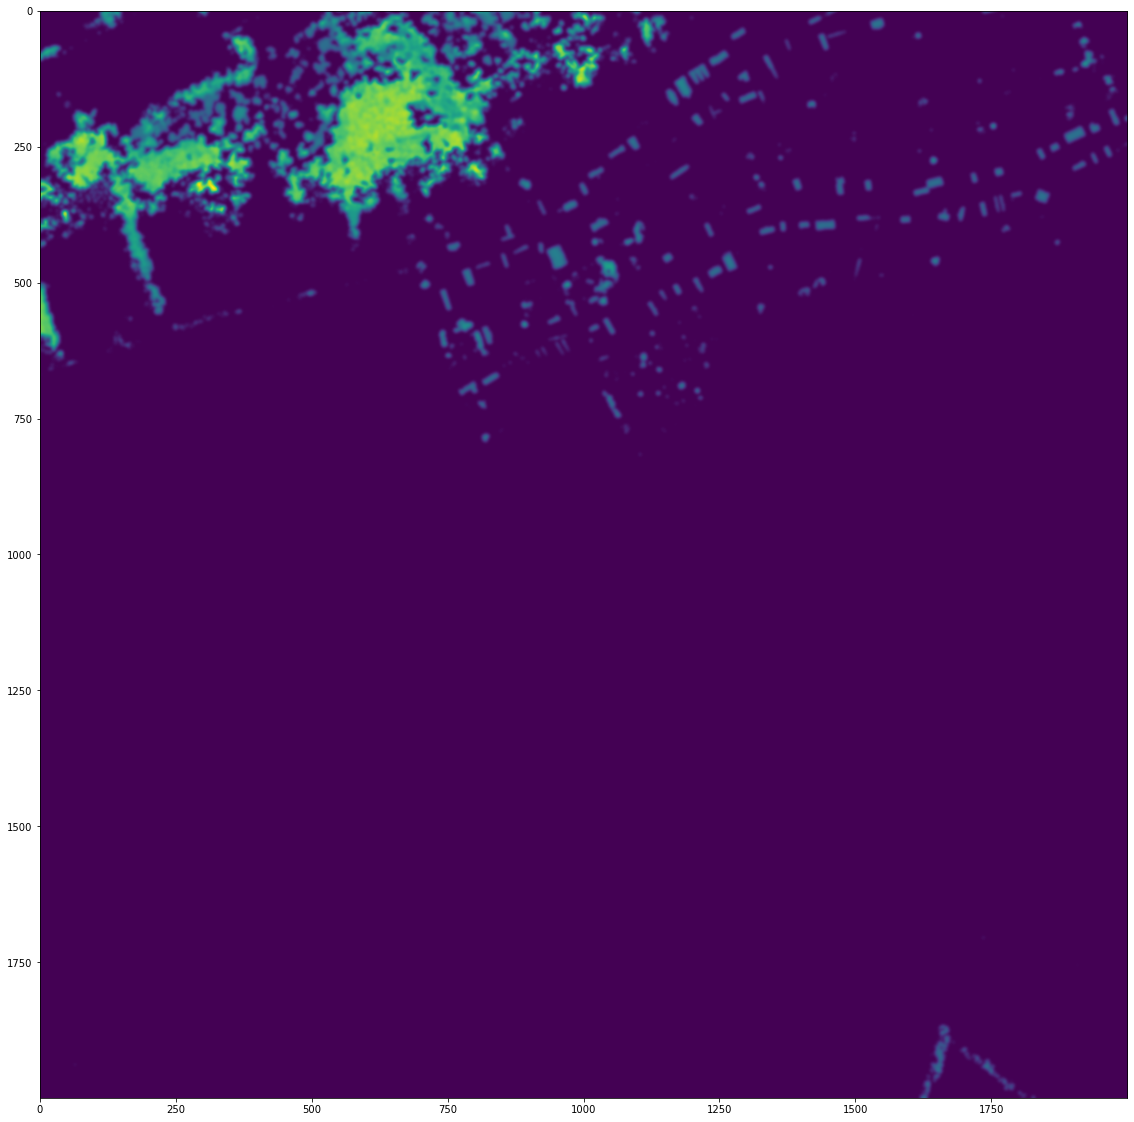

In [20]:
from scipy import ndimage as ndi
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float
from PIL import Image
import numpy
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [5, 5]

#lade bild als numpy.array
file = "ndom50_32282_5659_1_nw_2021.tif"
im = numpy.array(Image.open(file))
#scaliere in pixel-werte größer 0
m = - numpy.min(im)
im = im + m

""" #scaliere in range(0,255) und als integer-array:
m = numpy.max(im)
print(m)
im = ((im/m) *255).astype(numpy.int32)
"""
print(im)
plt.imshow(im)
plt.show()

#setze alle pixelwerte < thresshold = 0, um den boden zu glätten
#sonst werden bei jeder kleinen bodenwelle lokale maxima gefunden
threshhold = 10
im = numpy.where(im > threshhold, im, 0)
print(im)

plt.imshow(im)
plt.show()
##gaussischer filter:
im = gaussian_filter(im, sigma=3)

#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(im)
plt.show()


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


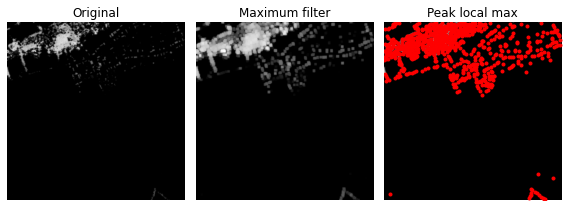

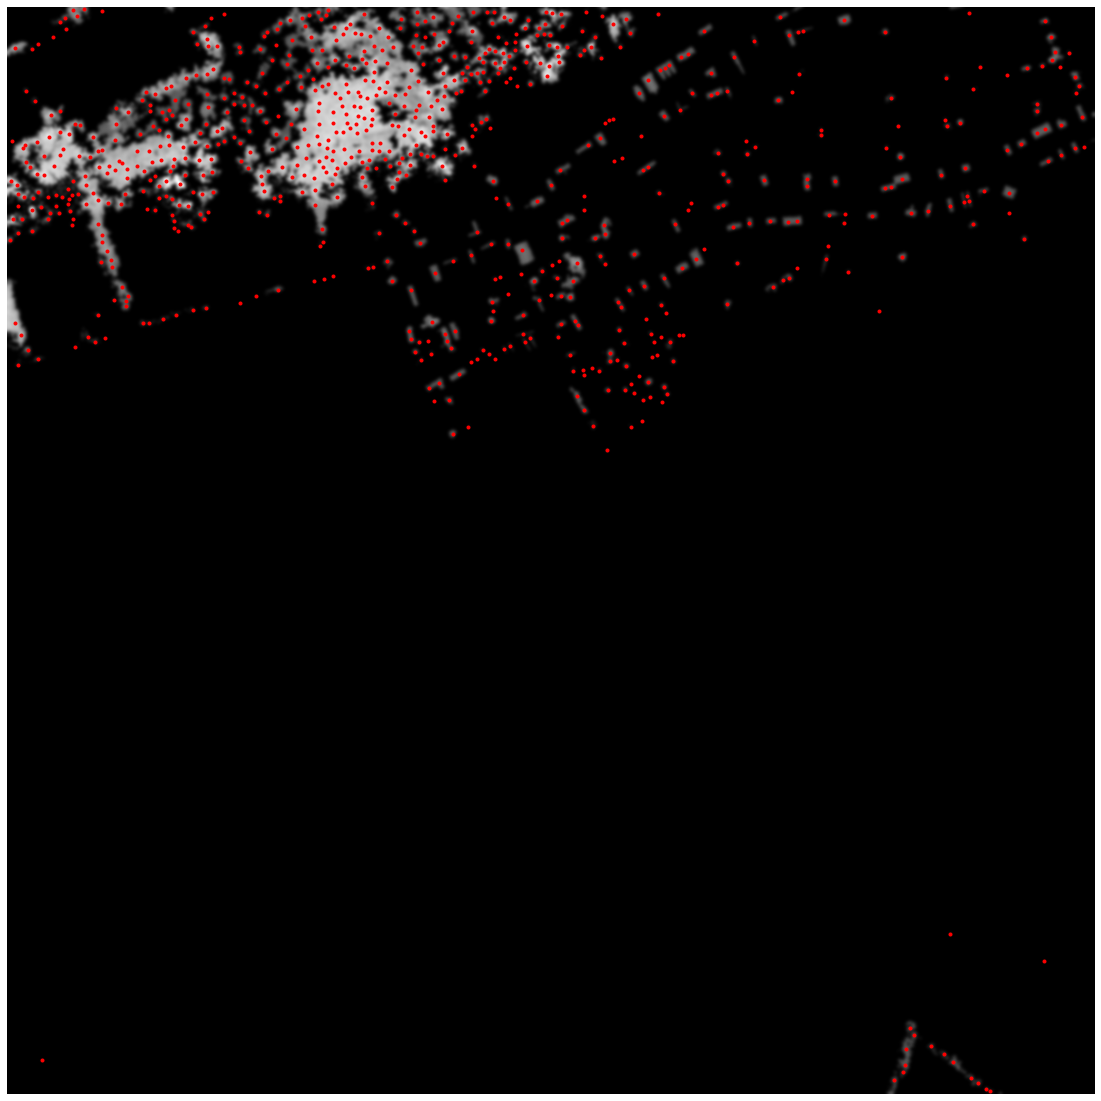

In [23]:
#wenn hier die maxima im einfarbigen bereich auftauchen, ist der threshold oben zu niedrig
#hier kann über den min-distance-wert skaliert werden:
min_distance = 4

print(im)
image_max = ndi.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=min_distance)




# display results:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

plt.imshow(im, cmap=plt.cm.gray)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.axis('off')
plt.show()
